In [66]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
import SEMP
import pyswarms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
[r_STA,r_WI,r_PSP] = [0.9669,1.0015*0.99,0.2266]
[alpha_STA,alpha_WI,alpha_PSP] = np.array([-97.1256,0,-342.8451]) *np.pi/180

In [20]:
PSPdataset = np.load('tmpData/psp_LE.npz',allow_pickle=True)
WISTAdataset = np.load('tmpData/WI_STA_LE.npz')
STAdataset = np.load('tmpData/STA_data.npz')
WIdataset = np.load('tmpData/WI_data.npz')


In [35]:
freq_PSP = PSPdataset['freq_PSP']
t_PSP = PSPdataset['t_PSP']
freq_WI  = WISTAdataset['freq_WI']*1e3
freq_STA = WISTAdataset['freq_STA']*1e3
t_WI  = WISTAdataset['t_WI']
t_STA = WISTAdataset['t_STA']

data_WI = WIdataset['data_WI']
data_STA = STAdataset['data_STA']
ds_t_WI = WIdataset['ds_t_WI']
ds_f_WI = WIdataset['ds_f_WI']*1e3
ds_t_STA = STAdataset['ds_t_STA']
ds_f_STA = STAdataset['ds_f_STA']*1e3

anchor_dt = PSPdataset['anchor_dt']
data_PSP = PSPdataset['data_PSP']
ds_t_PSP = PSPdataset['ds_t_PSP']
ds_f_PSP = PSPdataset['ds_f_PSP']

In [14]:
# x: [t0,theta0,vs]
v_sw = 400
Min_Func = lambda x:( SEMP.Dt_STA_WI_PSP(freq_STA,freq_WI,freq_PSP,
        t_STA,t_WI,t_PSP, x[:,0],x[:,1],x[:,2],v_sw,alpha_STA,alpha_WI,
        alpha_PSP,r_STA,r_WI,r_PSP,Ne_par=2.0) )


In [15]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=50, dimensions=3,
                                    options=options,bounds=([0,-0*np.pi,0],[5000,2*np.pi,3e5]))

In [16]:

stats = optimizer.optimize(Min_Func, iters=100)

2021-06-20 16:40:30,929 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=18.5
2021-06-20 16:40:32,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.513761049407215, best pos: [2.1376086e+03 4.3888049e+00 3.5818527e+04]


In [47]:
f_model = np.logspace(4.5,7,30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_PSP,r_satellite_AU=r_PSP,Ne_par=2.0)
    t_model_STA[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_STA,r_satellite_AU=r_STA,Ne_par=2.0)
    t_model_WI[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_WI,r_satellite_AU=r_WI,Ne_par=2.0)

array([2.1376086e+03, 4.3888049e+00, 3.5818527e+04])

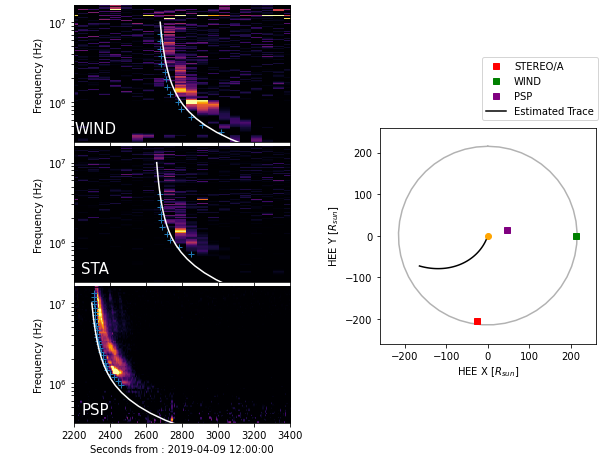

In [86]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,6.5)) 
ax = fig.add_axes([0.15,0.2,0.6,0.29])

im = NonUniformImage(ax, interpolation='nearest',extent=[ds_t_PSP[0],ds_t_PSP[-1],ds_f_PSP[0],ds_f_PSP[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_PSP[0],ds_f_PSP[-1],ds_f_PSP.shape[0])
im.set_data(ds_t_PSP,lin_freq,(data_PSP.T))
ax.images.append(im)
ax.set_yscale('log')
im.set_clim([0,3e-16])
ax.set_xlim([2200,3400])
ax.set_ylim([ds_f_PSP[0],ds_f_PSP[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(anchor_dt))
ax.plot(t_PSP,freq_PSP,'C0+')
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax.set_ylabel('Frequency (Hz)')
ax.text(0.1, 0.1,'PSP',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=15)

ax1 = fig.add_axes([0.15,0.5,0.6,0.29])

im1 = NonUniformImage(ax1, interpolation='nearest',extent=[ds_t_STA[0],ds_t_STA[-1],ds_f_STA[0],ds_f_STA[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_STA[0],ds_f_STA[-1],ds_f_STA.shape[0])
im1.set_data(ds_t_STA,lin_freq,(data_STA.T))
ax1.images.append(im1)
ax1.set_yscale('log')
im1.set_clim([0,2])
ax1.set_xlim([2200,3400])
ax1.set_ylim([ds_f_STA[0],ds_f_STA[-1]])
ax1.set_aspect('auto', 'datalim')
ax1.plot(t_STA,freq_STA,'C0+')
ax1.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax1.text(0.1, 0.1,'STA',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     fontsize=15)
     
ax1.set_ylabel('Frequency (Hz)')
ax1.xaxis.set_ticklabels([]) 


ax2 = fig.add_axes([0.15,0.8,0.6,0.29])

im2 = NonUniformImage(ax2, interpolation='nearest',extent=[ds_t_WI[0],ds_t_WI[-1],ds_f_WI[0],ds_f_WI[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_WI[0],ds_f_WI[-1],ds_f_WI.shape[0])
im2.set_data(ds_t_WI,lin_freq,(data_WI.T))
ax2.images.append(im2)
ax2.set_yscale('log')
im2.set_clim([0,0.1])
ax2.set_xlim([2200,3400])
ax2.set_ylim([ds_f_WI[0],ds_f_WI[-1]])
ax2.set_aspect('auto', 'datalim')
ax2.plot(t_WI,freq_WI,'C0+')
ax2.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax2.text(0.1, 0.1,'WIND',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     fontsize=15)
     
ax2.set_ylabel('Frequency (Hz)')
ax2.xaxis.set_ticklabels([]) 

ax.plot(t_model_PSP,f_model,'w')
ax1.plot(t_model_STA,f_model,'w')
ax2.plot(t_model_WI,f_model,'w')

#fig.savefig('img/PSP.pdf')


ax3 = fig.add_axes([1,0.3,0.6,0.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU,np.cos(tmp_t)*R_AU,'k-',alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU,r_WI*np.sin(0)*R_AU,'s',color='green',label='WIND')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU,r_STA*np.sin(alpha_STA)*R_AU,'s',color='red',label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU,r_PSP*np.sin(alpha_PSP)*R_AU,'s',color='purple',label='PSP')

r = np.linspace(1,180,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)
markSpiral,=ax3.plot(r*np.cos(theta_spiral)/r_sun2km,r*np.sin(theta_spiral)/r_sun2km,'k',label='Estimated Trace')



ax3.plot(0,0,'o',color='orange')
ax3.set_xlim([-260,260])
ax3.set_ylim([-260,260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA,markWI,markPSP, markSpiral],  bbox_to_anchor=(0.45, 1.35), loc='upper left')


In [89]:
stats[1][1]*180/np.pi-360

-108.54000233930444

In [67]:
fig.savefig('img/combined.pdf')

400